# Computer Vision 2020, CSE UoI. 
## TSOPOURIDIS GRIGORIOS, AM:3358
### Final project, 20/7/2020


In [1]:
#TSOPOURIDIS GRIGORIOS, AM:3358
#tensorflow version: 1.15.0
#python version: 3.7.7 64-bit
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
import tensorflow as tf

### Download the model.

In [2]:
#Download URLs of the pre-trained mobilenetv2 model
_MODEL_NAME = 'mobilenetv2_coco_voctrainaug'
_MODEL_URL = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'
  
_TARBALL_NAME = 'deeplab_model.tar.gz'
  
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)
#download the model from a given path:
download_path = os.path.join(model_dir, _TARBALL_NAME)
print('Downloading model...')
urllib.request.urlretrieve(_MODEL_URL,
                   download_path)
print('Download completed! Loading DeepLab model...')

Download completed! Loading DeepLab model...


## Create the DeepLab Model Class
The model will do the following:
* Load the latest version of the pretrained mobileNet DeepLab model
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and a legend of the meaning of colors of the various image regions

mobilenet is used due to the low resources required.
Code used/modeled after the deeplab_demo notebook.

In [3]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.
    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])
  #Plot the images on screen.
  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

#Pascal-VOC labels:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Load the model.

In [4]:
MODEL = DeepLabModel(download_path)
print('Model loaded successfully!')

Model loaded successfully!


### 1o erotima function:
#### Uses the loaded model to run semantic segmentation and visualizes the results. (1o erotima)


In [5]:
#Uses the model to run semantic segmentation and visualizes the results. (1o erotima)
def runSegmModel(filepath, layername = 'SemanticPredictions'):
    MODEL.OUTPUT_TENSOR_NAME = layername+':0'
    image_path = filepath
    image = Image.open(image_path)

    resized_im, seg_map = MODEL.run(image)
    vis_segmentation(resized_im, seg_map)


### 2o erotima function:
#### Gets a layer (layer name input) output and transforms it with PCA to a 3 channel colored image. (2o erotima)

In [6]:
#Gets layername layer output and transforms it to 3 channel image. (2o erotima)
def layer3DPCA(layername, filename):
    #print(MODEL.sess.graph.get_operations())
    #Change the model layer and run it to get the results of a specific layer.
    MODEL.OUTPUT_TENSOR_NAME = layername+':0'
    image_path = filename
    image = Image.open(image_path)
    resized_im, seg_map = MODEL.run(image)
    seg_map = np.asarray(seg_map)
    print(seg_map.shape)
    #reshape data for PCA input.
    N = seg_map.shape[0]*seg_map.shape[1]
    C = seg_map.shape[-1]
    X = np.reshape(seg_map, [N, C])
    print('Shape of X(initial data): {}'.format(X.shape))
    X = PCA(n_components=3).fit_transform(X)
    print('Shape of X after PCA:' + str(X.shape))
    #Reshape PCA'd data to image format with 3 channels.
    deepfeats_reduced = np.reshape(X, [seg_map.shape[0], seg_map.shape[1], 3])
    print('Image from '+layername +' layer and PCA:')
    plt.imshow(deepfeats_reduced)
    plt.show()
    print('Original Image:')
    plt.imshow(image)
    plt.show()

### 3o erotima function:
#### Gets a layer (layer name input) output and transforms it with PCA to a 8 channel data array NxMx8, uses Kmeans algorithm to (segment) binarize the image (2-color) and displays it. (3o erotima)

In [7]:
#(2)Kmeans layer output PCA using 8 channels.  
def layer8Kmeans(layername, filename):
    #print(MODEL.sess.graph.get_operations())
    MODEL.OUTPUT_TENSOR_NAME = layername+':0'
    image_path = filename
    image = Image.open(image_path)
    resized_im, seg_map = MODEL.run(image)
    seg_map = np.asarray(seg_map)

    #Reshape the data for PCA input.
    N = seg_map.shape[0]*seg_map.shape[1]
    C = seg_map.shape[-1]
    X = np.reshape(seg_map, [N, C])
    #Call PCA on the model results.
    print('Shape of X(initial data): {}'.format(X.shape))
    X = PCA(n_components=8).fit_transform(X)
    print('Shape of X after PCA:' + str(X.shape))
    deepfeats_reduced = np.reshape(X, [seg_map.shape[0], seg_map.shape[1], 8])
    
    #prepare image for kmeans and call it from sklearn.
    print('Preparing image for KMeans....')
    w, h, d = original_shape = tuple(deepfeats_reduced.shape)
    image_array = np.reshape(deepfeats_reduced, (w * h, d))
    kmeans = KMeans(n_clusters= 2, random_state=0).fit(image_array)
    #apply kmeans and reshape it to an binary image format.
    kmeans_result = kmeans.predict(image_array)
    kmeans_image = np.reshape(kmeans_result, [seg_map.shape[0], seg_map.shape[1]])
    print('Image after KMeans:')
    plt.imshow(kmeans_image)

## Examples of use (Image Segmentation (Proto erotima)): 

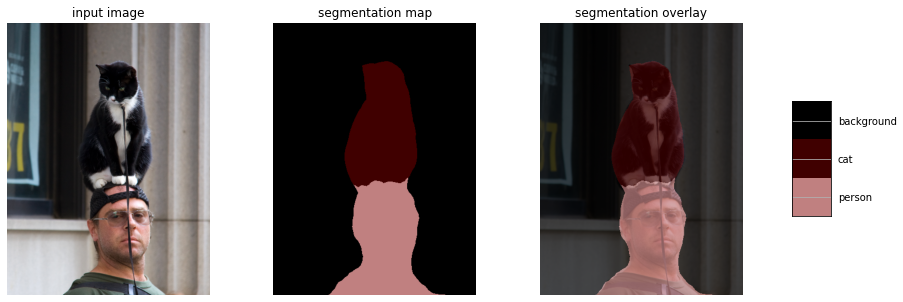

In [8]:
runSegmModel('mancat.jpg')

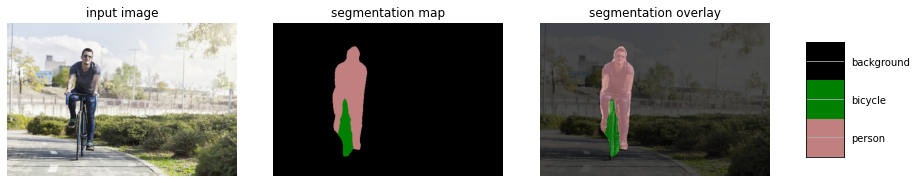

In [9]:
runSegmModel('manbike.jpg')

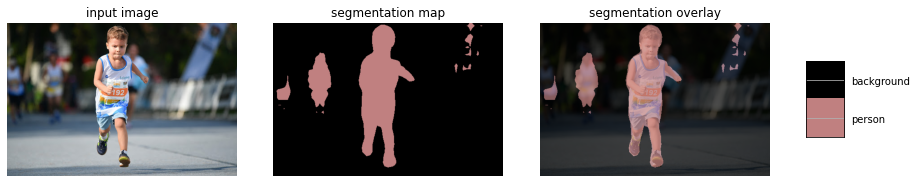

In [10]:
runSegmModel('kidrun.jpg')

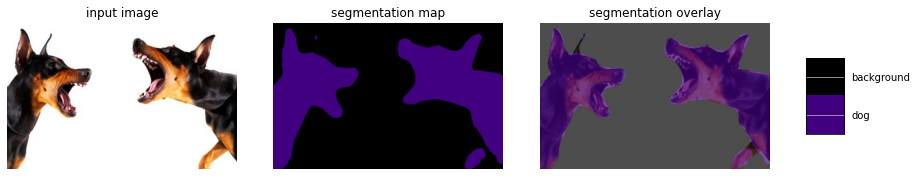

In [11]:
runSegmModel('dogbark.jpg')

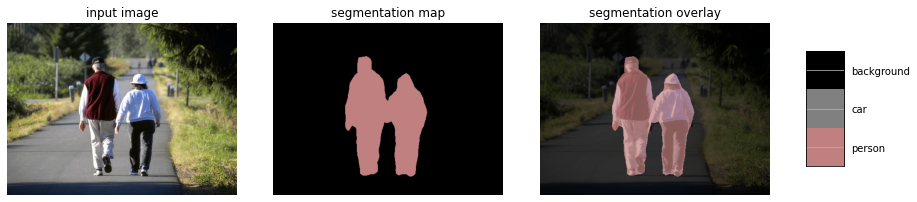

In [12]:
runSegmModel('peoplewalk.jpg')

Way to get graph layers/operations: print(MODEL.sess.graph.get_operations())

## Examples of use: Layer PCA (2o erotima). Images not resized/upscaled

### Called on a random layer for each image.

(513, 513, 21)
Shape of X(initial data): (263169, 21)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of X after PCA:(263169, 3)
Image from ResizeBilinear_3 layer and PCA:


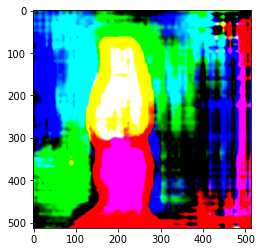

Original Image:


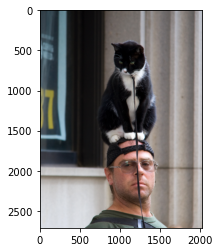

In [13]:
layer3DPCA('ResizeBilinear_3','mancat.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(65, 65, 256)
Shape of X(initial data): (4225, 256)
Shape of X after PCA:(4225, 3)
Image from concat_projection/Relu layer and PCA:


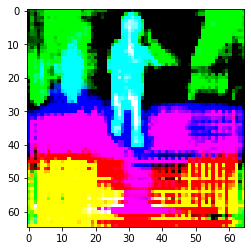

Original Image:


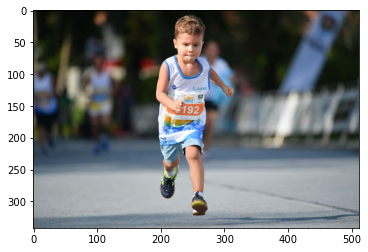

In [14]:
layer3DPCA('concat_projection/Relu','kidrun.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(65, 65, 256)
Shape of X(initial data): (4225, 256)
Shape of X after PCA:(4225, 3)
Image from concat_projection/Conv2D layer and PCA:


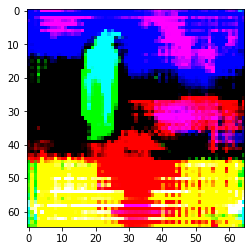

Original Image:


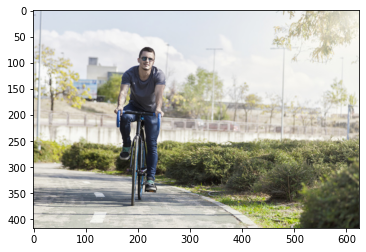

In [15]:
layer3DPCA('concat_projection/Conv2D','manbike.jpg')

(513, 513, 21)
Shape of X(initial data): (263169, 21)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of X after PCA:(263169, 3)
Image from ResizeBilinear_3 layer and PCA:


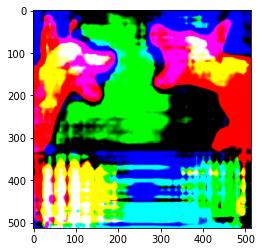

Original Image:


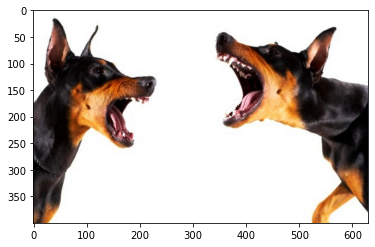

In [16]:
layer3DPCA('ResizeBilinear_3','dogbark.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(65, 65, 256)
Shape of X(initial data): (4225, 256)
Shape of X after PCA:(4225, 3)
Image from concat_projection/BatchNorm/FusedBatchNorm layer and PCA:


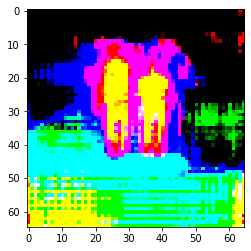

Original Image:


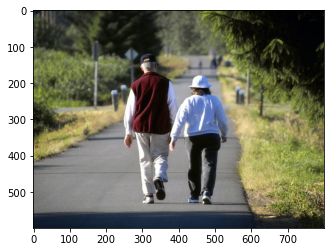

In [17]:
layer3DPCA('concat_projection/BatchNorm/FusedBatchNorm','peoplewalk.jpg')

## Examples of use: 8 channel layer PCA and (2)kmeans segmentation.

### Called on a random layer for each image.

Shape of X(initial data): (263169, 21)
Shape of X after PCA:(263169, 8)
Preparing image for KMeans....
Image after KMeans:


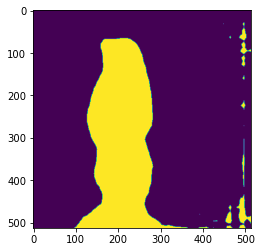

In [18]:
layer8Kmeans('ResizeBilinear_3','mancat.jpg')

Shape of X(initial data): (4225, 256)
Shape of X after PCA:(4225, 8)
Preparing image for KMeans....
Image after KMeans:


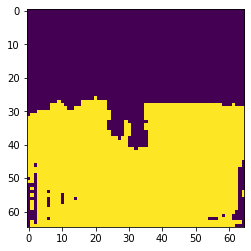

In [19]:
layer8Kmeans('concat_projection/Relu','kidrun.jpg')

Shape of X(initial data): (4225, 256)
Shape of X after PCA:(4225, 8)
Preparing image for KMeans....
Image after KMeans:


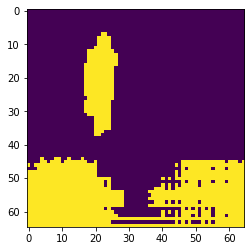

In [20]:
layer8Kmeans('concat_projection/Conv2D','manbike.jpg')

Shape of X(initial data): (263169, 21)
Shape of X after PCA:(263169, 8)
Preparing image for KMeans....
Image after KMeans:


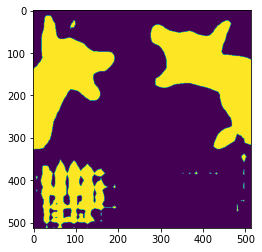

In [21]:
layer8Kmeans('ResizeBilinear_3','dogbark.jpg')

Shape of X(initial data): (4225, 256)
Shape of X after PCA:(4225, 8)
Preparing image for KMeans....
Image after KMeans:


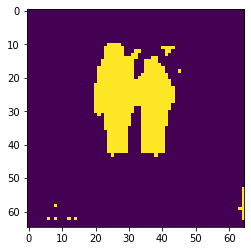

In [22]:
layer8Kmeans('concat_projection/BatchNorm/FusedBatchNorm','peoplewalk.jpg')